In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.parameter_estimation import (
    LeastSquares,
    TotalLeastSquares,
    RecursiveLeastSquares,
    NonNegativeLeastSquares,
    LeastMeanSquares,
    AffineLeastMeanSquares,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.save_load import save_model, load_model

warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
# read data from pickle 
building_results = pd.read_pickle('C:/Users/yangzhec/OneDrive - KTH/Projects/HYSTORE/PCM_flexibility_mdp/data/building_results.pkl')
office_elec = pd.read_pickle('C:/Users/yangzhec/OneDrive - KTH/Projects/HYSTORE/PCM_flexibility_mdp/data/office_load.pkl')

In [5]:
# calculate the average temp by assuming single thermal zone
building_results['avetemp'] = (building_results['TAIR_Office1             '] + building_results['TAIR_Office2             '] +
                             building_results['TAIR_Office1             '] + building_results['TAIR_Office4             '] +
                             building_results['TAIR_Office5             '] + building_results['TAIR_Office6             '] +
                             building_results['TAIR_Office7             '] + building_results['TAIR_Office8             ']) / 8

In [6]:
# seperate cooling season data (Jun, Jul, and Aug) 
office_elec_cs = office_elec[(office_elec.index.month==6) | (office_elec.index.month==7) | (office_elec.index.month==8)]
building_results_cs = building_results[(building_results.index.month==6) | (building_results.index.month==7) | (building_results.index.month==8)]

In [7]:
total_df = pd.concat([building_results_cs, office_elec_cs], axis=1)
total_df['Electricity Demand-TOT Cooling'].shift(-1)
total_df.dropna(inplace=True, axis=0)

In [9]:
# split training and validation sets (Jun Jul as training, Aug as validation)
train_df = total_df[total_df.index.month!=8]
test_df = total_df[total_df.index.month==8]

X_train = train_df[['Electricity Demand-TOT Cooling', 'T                        ']].values.astype(float)
y_train = train_df['avetemp'].values.reshape(-1,1).astype(float)

X_test = test_df[['Electricity Demand-TOT Cooling', 'T                        ']].values.astype(float)
y_test = test_df['avetemp'].values.reshape(-1,1).astype(float)

Polynomial with FROLS estimator

In [17]:
basis_function = Polynomial(degree=2)
estimator = LeastSquares()

frols_model = FROLS(
    order_selection=True,
    n_terms=5,
    ylag=1,
    xlag=[[1], [1]],
    info_criteria="aic",
    estimator=estimator,
    basis_function=basis_function,
)

frols_model.fit(X=X_train, y=y_train)

In [21]:
yhat = frols_model.predict(X=X_test, y=y_test, steps_ahead=1)
rrse = root_relative_squared_error(y_test, yhat)
print(rrse)

0.20202732768143764


In [22]:
r = pd.DataFrame(
    results(
        frols_model.final_model,
        frols_model.theta,
        frols_model.err,
        frols_model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

      Regressors   Parameters             ERR
0         y(k-1)   1.0169E+00  9.99925988E-01
1        x2(k-1)  -4.2005E-03  2.24408063E-06
2  x2(k-1)y(k-1)  -1.8320E-03  1.06707386E-06
3      x2(k-1)^2   1.3518E-03  1.67985746E-07
4      x1(k-1)^2   3.7638E-03  2.14807743E-07


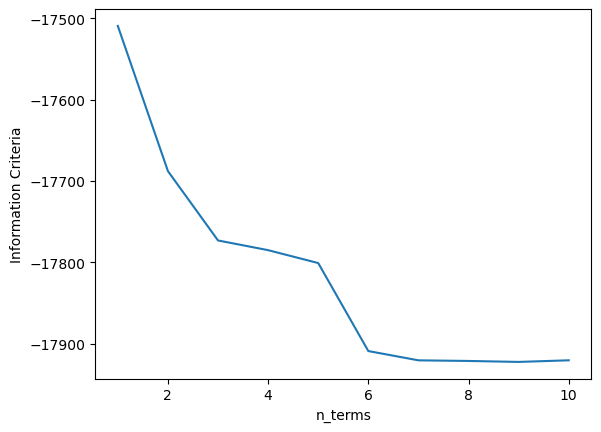

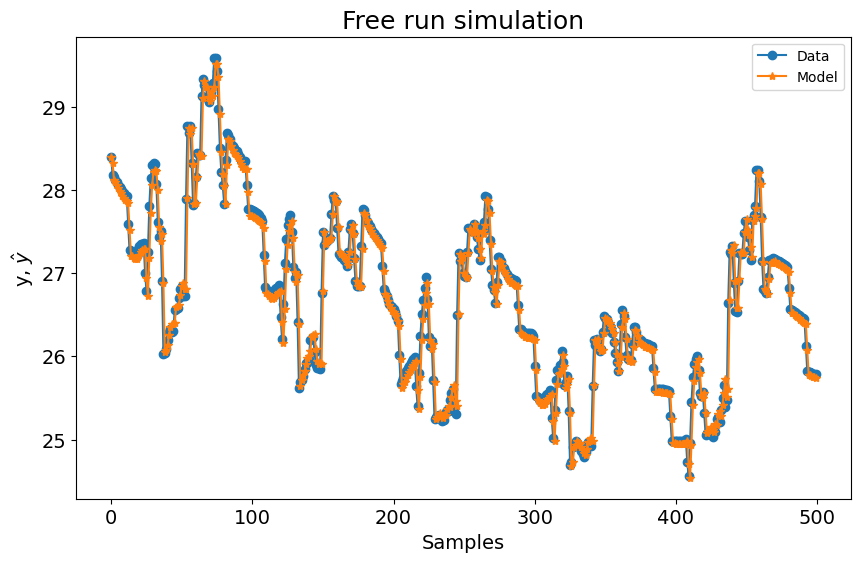

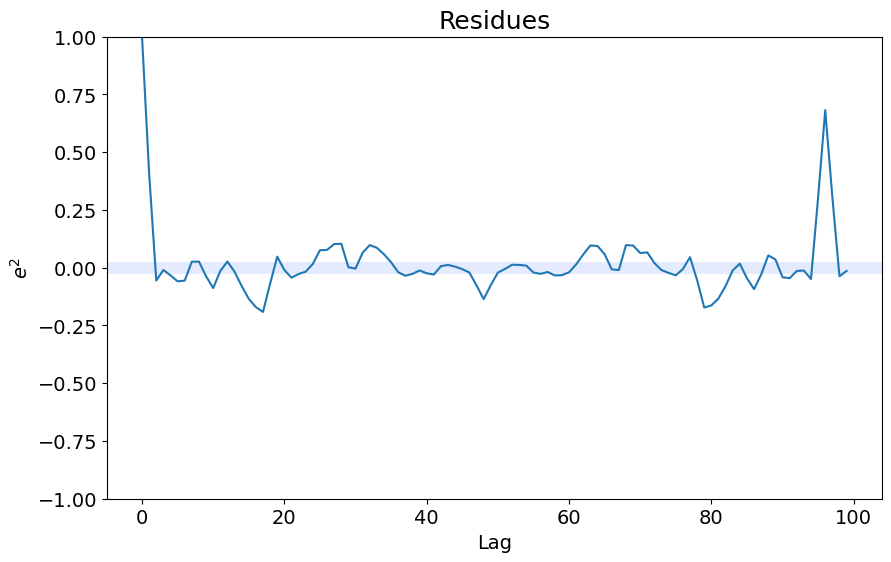

In [23]:
xaxis = np.arange(1, frols_model.n_info_values + 1)
plt.plot(xaxis, frols_model.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")
plot_results(y=y_test, yhat=yhat, n=500)
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

In [14]:
save_model(model=frols_model, file_name="indoor_frols.syspy")


 Original model 
       Regressors   Parameters             ERR
0         y(k-1)   1.0169E+00  9.99925988E-01
1        x2(k-1)  -4.2005E-03  2.24408063E-06
2  x2(k-1)y(k-1)  -1.8320E-03  1.06707386E-06
3      x2(k-1)^2   1.3518E-03  1.67985746E-07
4      x1(k-1)^2   3.7638E-03  2.14807743E-07

 Model Loaded from file 
       Regressors   Parameters             ERR
0         y(k-1)   1.0169E+00  9.99925988E-01
1        x2(k-1)  -4.2005E-03  2.24408063E-06
2  x2(k-1)y(k-1)  -1.8320E-03  1.06707386E-06
3      x2(k-1)^2   1.3518E-03  1.67985746E-07
4      x1(k-1)^2   3.7638E-03  2.14807743E-07

 Predictions are the same!


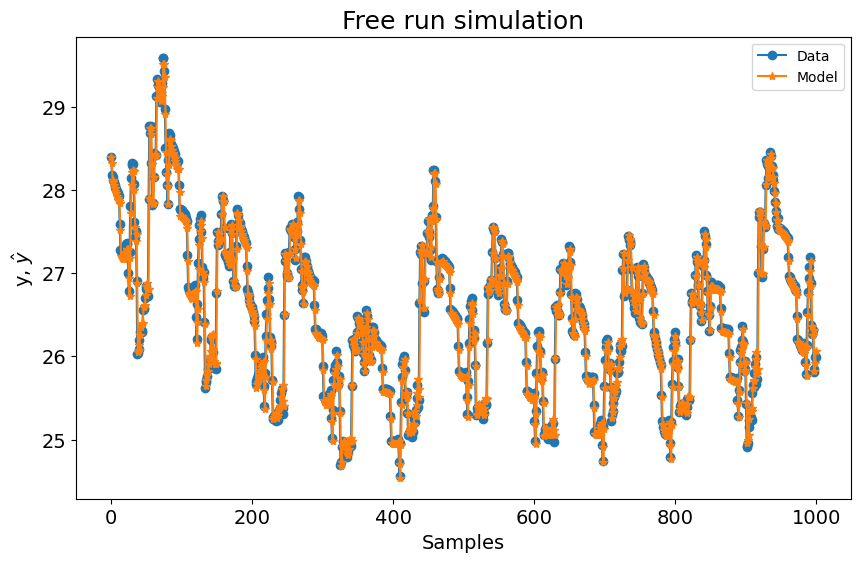

In [16]:
loaded_model = load_model(file_name="indoor_frols.syspy")
# Predicting output with loaded_model
yhat_loaded = loaded_model.predict(X=X_test, y=y_test, steps_ahead=1)

r_loaded = pd.DataFrame(
    results(
        loaded_model.final_model,
        loaded_model.theta,
        loaded_model.err,
        loaded_model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)

# Printing both: original model and model loaded from file
print("\n Original model \n", r)
print("\n Model Loaded from file \n", r_loaded)

# Checking predictions from both: original model and model loaded from file
if (yhat == yhat_loaded).all():
    print("\n Predictions are the same!")

# Ploting results
plot_results(y=y_test, yhat=yhat_loaded, n=1000)